### Testing network metrics

Testing core functions for network metrics.

In [1]:
# Adding GDa to path
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import brainconn as bc
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from GDa.net.static_measures import (
    _betweenness,
    _clustering,
    _coreness,
    _degree,
    _efficiency,
    _modularity,
    _shortest_path,
)

#### Loading adjacency

In [3]:
A = np.loadtxt("data/adjacency.txt")

In [4]:
n_nodes = len(A)

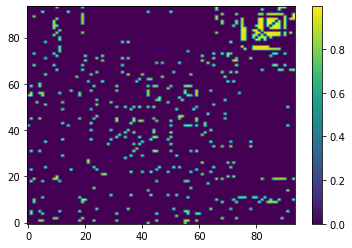

In [5]:
plt.imshow(A, aspect="auto", origin="lower")
plt.colorbar()

#### Strength

In [6]:
S = _degree(A)

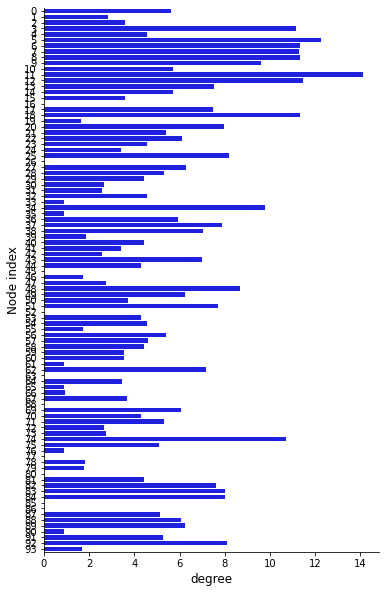

In [7]:
fig = plt.figure(figsize=(6, 10))
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=S, orient="h", color="b")
plt.xlabel("degree", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)

#### Clustering

In [8]:
C_bc = _clustering(A, backend="brainconn")
C_ig = _clustering(A, backend="igraph")

Text(0.5, 1.0, 'igraph')

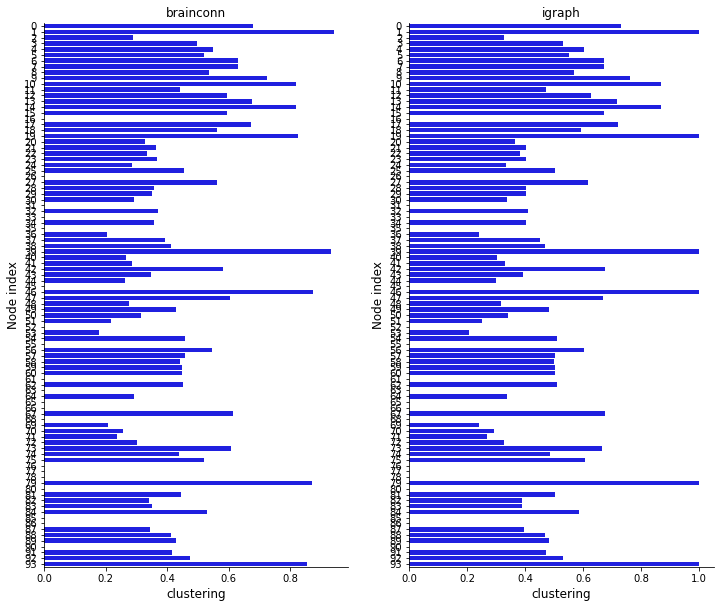

In [9]:
fig = plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=C_bc, orient="h", color="b")
plt.xlabel("clustering", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("brainconn")

plt.subplot(1, 2, 2)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=C_ig, orient="h", color="b")
plt.xlabel("clustering", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("igraph")

#### Betweenness

In [10]:
B_bc = _betweenness(A, backend="brainconn")
B_ig = _betweenness(A, backend="igraph")

Text(0.5, 1.0, 'igraph')

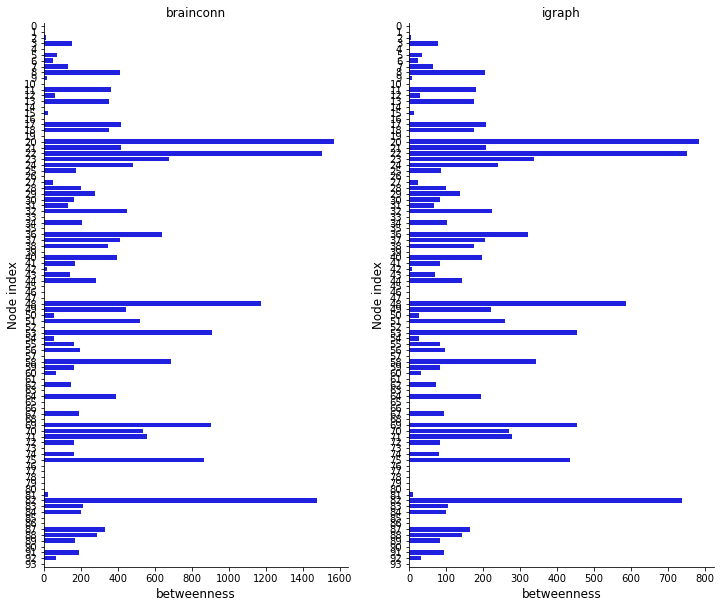

In [11]:
fig = plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=B_bc, orient="h", color="b")
plt.xlabel("betweenness", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("brainconn")

plt.subplot(1, 2, 2)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=B_ig, orient="h", color="b")
plt.xlabel("betweenness", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("igraph")

#### Coreness

In [12]:
K_ig = _coreness(A > 0, backend="igraph")
K_bc = _coreness(A > 0, backend="brainconn")

In [16]:
from GDa.net.layerwise import compute_nodes_coreness

Text(0.5, 1.0, 'igraph')

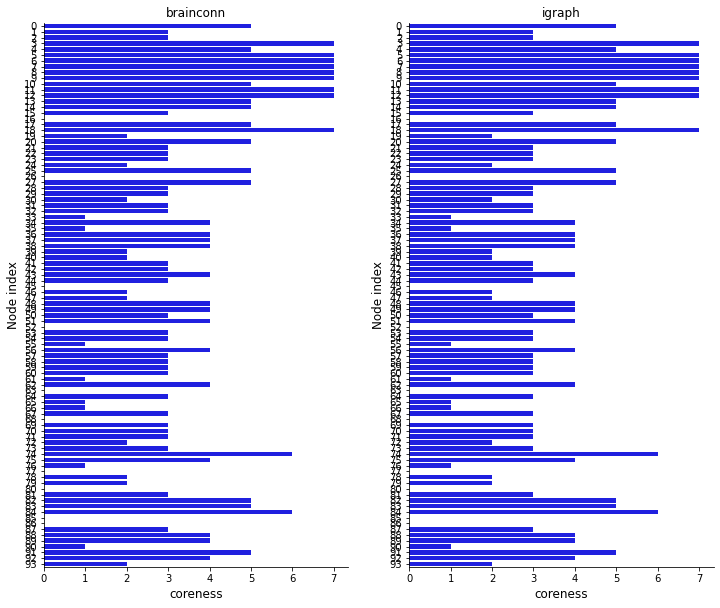

In [17]:
fig = plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=K_bc, orient="h", color="b")
plt.xlabel("coreness", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("brainconn")

plt.subplot(1, 2, 2)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=K_ig, orient="h", color="b")
plt.xlabel("coreness", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("igraph")

#### Efficiency

In [18]:
E_bc = _efficiency(A, backend="brainconn")
E_ig = _efficiency(A, backend="igraph")

Text(0.5, 1.0, 'igraph')

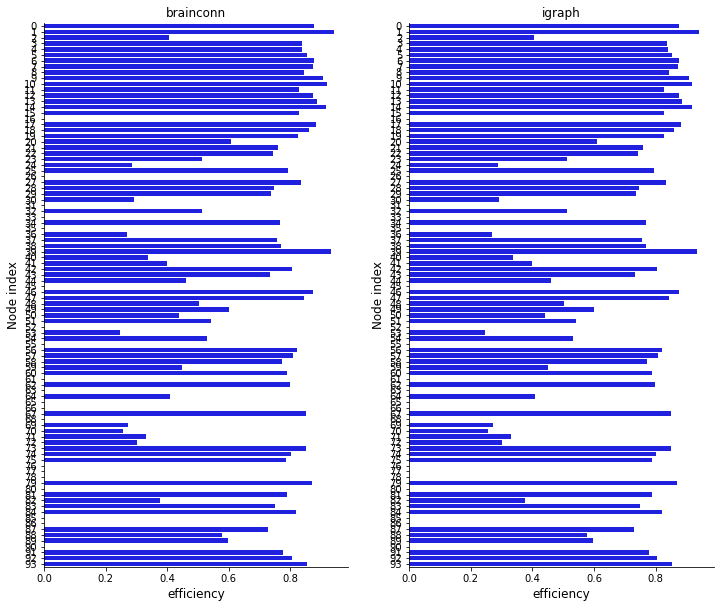

In [19]:
fig = plt.figure(figsize=(12, 10))

plt.subplot(1, 2, 1)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=E_bc, orient="h", color="b")
plt.xlabel("efficiency", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("brainconn")

plt.subplot(1, 2, 2)
sns.barplot(y=np.arange(n_nodes, dtype=int)[::-1], x=E_ig, orient="h", color="b")
plt.xlabel("efficiency", fontsize=12)
plt.ylabel("Node index", fontsize=12)
sns.despine(fig, top=True, right=True)
plt.title("igraph")

#### Shortest-path 

In [20]:
SP_ig = _shortest_path(A, backend="igraph")
SP_bc = _shortest_path(A, backend="brainconn")

Text(0.5, 0, 'Node index')

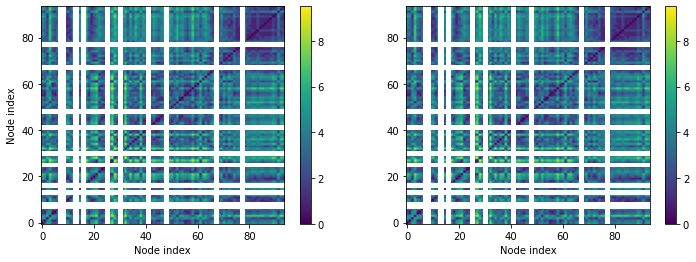

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(SP_ig, aspect="auto", origin="lower")
plt.colorbar()
plt.ylabel("Node index")
plt.xlabel("Node index")
plt.subplot(1,2,2)
plt.imshow(SP_bc, aspect="auto", origin="lower")
plt.colorbar()
plt.xlabel("Node index")

#### Modularity

In [22]:
M_ig = []
M_bc = []

In [23]:
for i in range(200):
    _, out = _modularity(A, backend="igraph")
    M_ig += [out]
    _, out = _modularity(A, backend="brainconn")
    M_bc += [out]

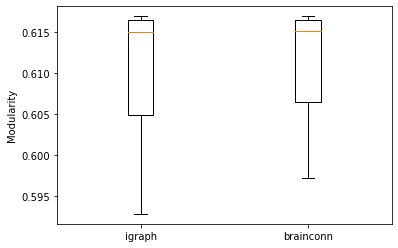

In [24]:
plt.boxplot([M_ig, M_bc])
plt.ylabel("Modularity")
plt.xticks([1,2],['igraph', 'brainconn']);